Epoch 1, Train Loss: 0.7161, Train Acc: 0.5000, Validation Loss: 0.6937, Validation Accuracy: 0.6000
Epoch 2, Train Loss: 0.6759, Train Acc: 0.6333, Validation Loss: 0.6434, Validation Accuracy: 0.7333
Epoch 3, Train Loss: 0.6522, Train Acc: 0.5000, Validation Loss: 0.6394, Validation Accuracy: 0.7333
Epoch 4, Train Loss: 0.6399, Train Acc: 0.5833, Validation Loss: 0.6414, Validation Accuracy: 0.7333
Epoch 5, Train Loss: 0.6170, Train Acc: 0.6167, Validation Loss: 0.6450, Validation Accuracy: 0.7333
Epoch 6, Train Loss: 0.5999, Train Acc: 0.6500, Validation Loss: 0.6530, Validation Accuracy: 0.6667
Epoch 7, Train Loss: 0.5805, Train Acc: 0.7833, Validation Loss: 0.6604, Validation Accuracy: 0.6667
Epoch 8, Train Loss: 0.5746, Train Acc: 0.7667, Validation Loss: 0.6725, Validation Accuracy: 0.6667
Epoch 9, Train Loss: 0.5701, Train Acc: 0.8000, Validation Loss: 0.6769, Validation Accuracy: 0.6667
Epoch 10, Train Loss: 0.5556, Train Acc: 0.8167, Validation Loss: 0.6765, Validation Accura

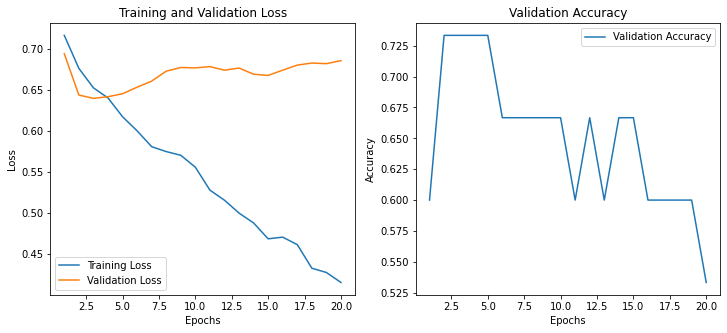

In [5]:
import importlib
import variables
importlib.reload(variables)

import os
import numpy as np
import pandas as pd
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
import variables as v  # اطمینان حاصل کنید که این فایل شامل مسیرها و نام‌های متغیرهای صحیح است
import itertools
import matplotlib.pyplot as plt
import shutil


# Define parameters (these are unchanged)
data_type = "ica_filtered"
test_type = "Arithmetic"
epochs = 20
sfreq = 1
batch_size = 32

learning_rate = 0.00001
patience = 10
min_delta = 0.001
model_save_dir = "epoch_model"
num_layers = 4
num_neurons = [64,32,32,64]
dropout_rate = 0.1


# Function to load the dataset
def load_dataset(data_type=data_type, test_type=test_type):
    # Ensure test and data types are valid
    assert test_type in v.TEST_TYPES
    assert data_type in v.DATA_TYPES

    # Check for data-type/test-type compatibility
    if data_type == "ica_filtered" and test_type not in v.TEST_TYPES:
        print("Data of type", data_type, "does not have test type", test_type)
        return None

    # Get the directory path for the data type
    dir_path = getattr(v, f"DIR_{data_type.upper()}")
    dataset = []

    # Define key for accessing data in MATLAB files
    if data_type == "raw":
        data_key = 'Data'
    elif data_type == "wt_filtered" or data_type == "ica_filtered":
        data_key = 'Clean_data'

    # Load data from files
    for filename in os.listdir(dir_path):
        try:
            if test_type in filename:
                filepath = os.path.join(dir_path, filename)
                mat_contents = scipy.io.loadmat(filepath)
                data = mat_contents[data_key]
                dataset.append(data)
        except Exception as e:
            print(f"Failed to load {filename}: {e}")
    return np.array(dataset)

# Function to load labels
def load_labels():
    # Check if the labels file exists
    if not os.path.exists(v.LABELS_PATH):
        print(f"Labels file not found at {v.LABELS_PATH}")
        return None

    # Load and process labels
    labels_df = pd.read_excel(v.LABELS_PATH)
    labels_df = labels_df.rename(columns=v.COLUMNS_TO_RENAME)
    labels_df = labels_df.iloc[1:]
    expected_columns = list(v.COLUMNS_TO_RENAME.values())

    # Check if all expected columns are present
    if not all(col in labels_df.columns for col in expected_columns):
        print("One or more expected columns are missing in the labels file.")
        return None

    # Convert labels to binary (greater than 5 becomes 1, else 0)
    labels = (labels_df > 5).astype(float)
    return labels

# Function to format labels
def format_labels(labels, test_type=test_type, epochs=1):
    # Ensure test type is valid and labels are loaded
    assert test_type in v.TEST_TYPES
    if labels is None or not len(labels):
        print("Labels are empty or not loaded properly.")
        return None
    if not isinstance(labels, pd.DataFrame):
        print("Labels are not a DataFrame.")
        return None

    # Check for missing columns in labels
    trial_columns = v.TEST_TYPE_COLUMNS[test_type]
    missing_columns = [col for col in trial_columns if col not in labels.columns]
    if missing_columns:
        print(f"Missing columns in labels: {missing_columns}")
        return None


    # Format labels for each trial
    formatted_labels = []
    for trial in trial_columns:
        formatted_labels.extend(labels[trial].tolist())
    return np.repeat(formatted_labels, epochs)

# Function to split data into epochs
def split_data(data, sfreq=sfreq):
    n_trials, n_channels, n_samples = data.shape
    n_epochs = n_samples // sfreq
    epoched_data = data.reshape(n_trials, n_channels, n_epochs, sfreq)
    return epoched_data




####################################################################################





# Custom class derived from Dataset for managing EEG data
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, output_size, num_layers=num_layers, num_neurons=num_neurons, dropout_rate=dropout_rate):
        super(SimpleNN, self).__init__()
        layers = []
        for i in range(num_layers):
            in_features = input_size if i == 0 else num_neurons[i - 1]
            out_features = num_neurons[i]
            layers.append(torch.nn.Linear(in_features, out_features))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_rate))
        self.layers = torch.nn.Sequential(*layers)
        self.fc_final = torch.nn.Linear(num_neurons[-1], output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        x = self.fc_final(x)
        x = self.sigmoid(x)
        return x

    
class EEG_CNN(torch.nn.Module):
    def __init__(self, num_channels, num_classes):
        super(EEG_CNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size=10, stride=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=10, stride=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)   
        
        self.flat = torch.nn.Flatten()
        
        self.fc1 = torch.nn.Linear(5760, 128)
        self.dropout1 = torch.nn.Dropout(0.1)
        
        self.fc2 = torch.nn.Linear(128, 64)
        self.dropout2 = torch.nn.Dropout(0.1)
        
        self.fc3 = torch.nn.Linear(64, 64)
        self.dropout3 = torch.nn.Dropout(0.1)
        
        self.fc4 = torch.nn.Linear(64, num_classes)
        
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flat(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


    
# Function for training the model for one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_items = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.reshape(-1, 32, 64, 50)
        pred = model(X)
        
        pred = pred.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_items += y.size(0)
        correct += (pred.round() == y).sum().item()
    return total_loss / len(dataloader), correct / total_items

# Function for validating the model for one epoch
def validate(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_items = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.reshape(-1, 32, 64, 50)
            pred = model(X)
            pred = pred.squeeze(1)
            total_loss += loss_fn(pred, y).item()
            total_items += y.size(0)
#             print(y.size(0), y.shape, pred.shape)
            correct += (pred.round() == y).sum().item()
    return total_loss / len(dataloader), correct / total_items


def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients for validation
        for data, labels in test_loader:
            data = data.reshape(-1, 32, 64, 50)
            outputs = model(data)
            outputs = outputs.squeeze(1)
            total += labels.size(0)
            correct += (outputs.round() == labels).sum().item()

    accuracy = correct / total
    return accuracy



# Class for implementing early stopping
class EarlyStopping:
    def __init__(self, patience=patience, min_delta=min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop


# Unit test functions
def test_data_loading():
    assert load_dataset(data_type, test_type) is not None
    assert load_labels() is not None

def test_model_initialization():
    model = SimpleNN(102400, v.N_CLASSES, num_layers=num_layers, num_neurons=num_neurons)
    assert model is not None

# Run unit tests
test_data_loading()
test_model_initialization()

# Main execution
dataset = load_dataset(data_type, test_type)
labels = load_labels()
if dataset is None or labels is None:
    print("Data or labels could not be loaded. Exiting.")
    exit()




# Process the data and labels
formatted_labels = format_labels(labels, test_type, epochs=1)
epoched_data = split_data(dataset, sfreq)
flattened_data = epoched_data.reshape(epoched_data.shape[0], -1)

# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(flattened_data, formatted_labels, test_size=0.5)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.75)

# Create datasets and loaders
train_dataset = EEGDataset(train_data, train_labels)
val_dataset = EEGDataset(val_data, val_labels)
test_dataset = EEGDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
input_size = flattened_data.shape[1]
output_size = v.N_CLASSES
# model = SimpleNN(102400, v.N_CLASSES, num_layers=num_layers, num_neurons=num_neurons)
model = EEG_CNN(32, v.N_CLASSES)


# Loss function, optimizer, and scheduler
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=1)
early_stopper = EarlyStopping(patience=patience, min_delta=min_delta)



# Create or clear the model save directory
if os.path.exists(model_save_dir):
    shutil.rmtree(model_save_dir)
os.makedirs(model_save_dir, exist_ok=True)

# Training and validation code (assuming other necessary functions are defined)
models_saved_count = 0
last_saved_epoch = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Validation
#     val_loss = validate(val_loader, model, criterion)
#     val_accuracy = evaluate_model(model, val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model for each epoch in the specified folder
    epoch_model_path = os.path.join(model_save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), epoch_model_path)
    models_saved_count += 1
    last_saved_epoch = epoch + 1  # Update the last saved epoch

    scheduler.step()

    if False and early_stopper(val_loss):
        print("Early stopping")
        break

# Function to load a trained SimpleNN model
def load_model(model_path):
    model = EEG_CNN(32, 1)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load the last saved model and evaluate
model_path_to_load = os.path.join(model_save_dir, f"model_epoch_{last_saved_epoch}.pth")
loaded_model = load_model(model_path_to_load)

# Assuming test_loader is already defined
if test_dataset is None or test_labels is None:
    print("Test data or labels could not be loaded. Exiting.")
    exit()

# test_loss = validate(test_loader, loaded_model, criterion)
test_accuracy = evaluate_model(loaded_model, test_loader)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


# Plotting the training loss and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()